In [51]:
import os
import s3fs
import json
import time
import random
import requests
import pprint

import seaborn as sns
import numpy as np
import pandas as pd

from PIL import Image
from ipyplot import plot_images

In [2]:
sns.set(rc={'figure.figsize':(12, 9)})

In [3]:
S3_ENDPOINT = f'http://{os.getenv("S3_HOST")}:4566'
API_ENDPOINT = f'http://{os.getenv("API_HOST")}:5000/task'

In [4]:
s3 = s3fs.S3FileSystem(client_kwargs={'endpoint_url': f'http://{os.getenv("S3_HOST")}:4566'})

### Helpers

In [8]:
performed_tasks = {}
def perform_task(params):
    api_response = requests.post(API_ENDPOINT, json=params).json()
    task_id = api_response['task_id']
    
    status = 'PENDING'
    while status == 'PENDING':
        time.sleep(3)
        response = requests.get(f'{API_ENDPOINT}/{task_id}').json()
        status = response['status']
        
    performed_tasks[task_id] = {
        'params': params,
        'status': status,
        'result': response['result']
    }
        
    if status != 'SUCCESS':
        raise Exception(response)
        
    return response['result']['s3_target']

In [94]:
def draw_images(items, source_folder, sample=3):
    sample_items = random.sample(items, sample)
    
    images = []
    for item in sample_items:
        with s3.open(f'{source_folder}/{item["image_id"]}.jpg') as f:
            images.append(np.asarray(Image.open(f)))
            
    plot_images(images, labels=[item['image_id'] for item in sample_items], custom_texts=[pprint.pformat(item) for item in sample_items], zoom_scale=1.0)

### Analyse artifacts

In [99]:
s3_target = perform_task({"gender": 'Men', 
                          'sub_category': 'Shoes', 
                          'start_year': 2012,
                          'apply_augmentation': True, 
                          'apply_model': True})

In [100]:
# filter results
with s3.open(f'{s3_target}/metadata.json') as f:
    metadata = json.load(f)


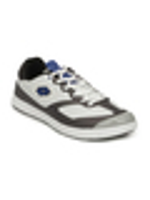
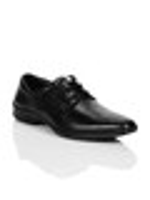
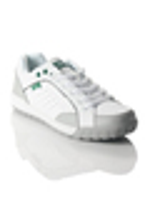


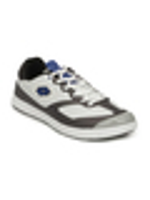
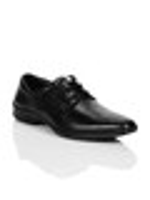
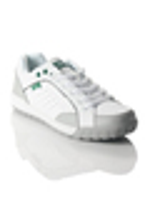

In [101]:
# sample of original images
draw_images(metadata, f'{s3_target}/images')


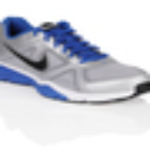
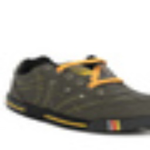
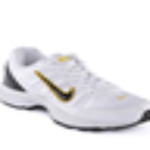


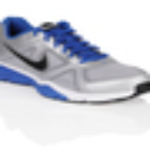
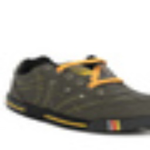
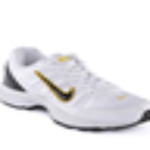

In [105]:
# sample of transformed images
draw_images(metadata, f'{s3_target}/augmentation')

In [106]:
# predictions
with s3.open(f'{s3_target}/predictions.json') as f:
    predictions = json.load(f)

In [104]:
print(f'Number of predictions: {len(predictions)}')
print(f'Prediciton output per image: massive_attr-{len(predictions[0]["massive_attr"])}, categories-{len(predictions[0]["categories"])}')

Number of predictions: 2625
Prediciton output per image: massive_attr-1000, categories-50


### 2 more queries

In [81]:
s3_sample_jewellery = perform_task({"gender": 'Women', 'sub_category': 'Jewellery'})


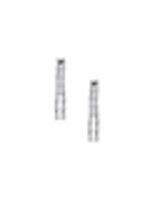
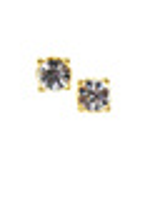
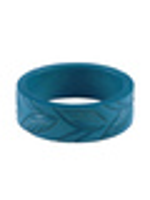


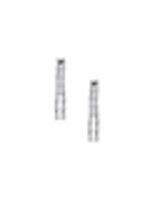
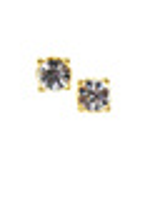
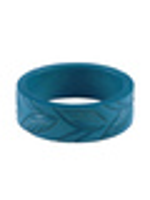

In [97]:
with s3.open(f'{s3_sample_jewellery}/metadata.json') as f:
    sample_metadata_1 = json.load(f)
    
draw_images(sample_metadata_1, f'{s3_sample_jewellery}/images')

In [82]:
s3_sample_winter_season = perform_task({"season": 'Winter', 'master_category': 'Footwear'})


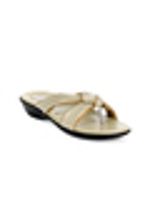
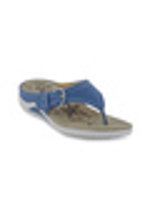
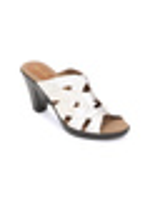


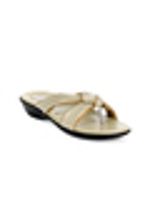
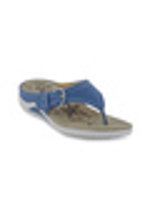
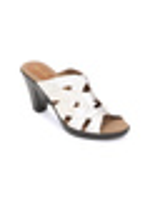

In [98]:
with s3.open(f'{s3_sample_winter_season}/metadata.json') as f:
    sample_metadata_2 = json.load(f)
    
draw_images(sample_metadata_2, f'{s3_sample_winter_season}/images')

### Analysis and visualization

In [110]:
with s3.open(f'{s3_target}/metadata.json') as f:
    df = pd.DataFrame(json.load(f))

In [111]:
categories = df.columns.difference(['image_id', 'year', 'display_name'])

In [112]:
df.head()

,image_id,gender,master_category,sub_category,article_type,base_colour,season,year,usage,display_name
0,39988,Men,Footwear,Shoes,Casual Shoes,White,Winter,2014,Casual,Gas Men Europa White Shoes
1,10268,Men,Footwear,Shoes,Formal Shoes,Black,Fall,2012,Formal,Clarks Men Hang Work Leather Black Formal Shoes
2,59435,Men,Footwear,Shoes,Formal Shoes,Black,Summer,2012,Formal,Arrow Men Black Formal Shoes
3,22198,Men,Footwear,Shoes,Casual Shoes,Black,Fall,2012,Casual,Timberland Men Black Casual Shoes
4,29570,Men,Footwear,Shoes,Casual Shoes,Purple,Summer,2012,Casual,Vans Men Classic Slip-On Purple & Black Shoes


In [113]:
df[categories].describe()

,article_type,base_colour,gender,master_category,season,sub_category,usage
count,2625,2625,2625,2625,2625,2625,2625
unique,4,28,1,1,4,1,4
top,Casual Shoes,Black,Men,Footwear,Summer,Shoes,Casual
freq,1497,947,2625,2625,1703,2625,1531


#### Article type

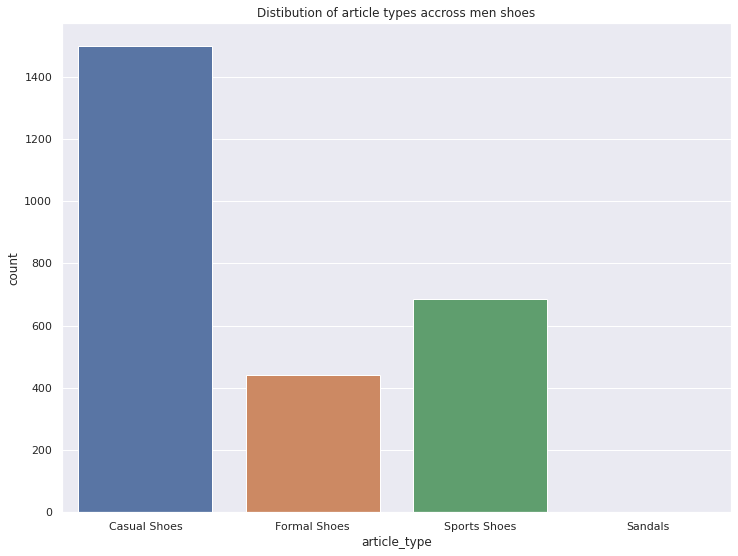

In [114]:
ax = sns.countplot(x = df['article_type'])
ax.set_title('Distibution of article types accross men shoes');

In [115]:
# There is only 2 sandals items - we need to check the whole dataset for this type
(df['article_type'] == 'Sandals').sum()

2

#### Colour

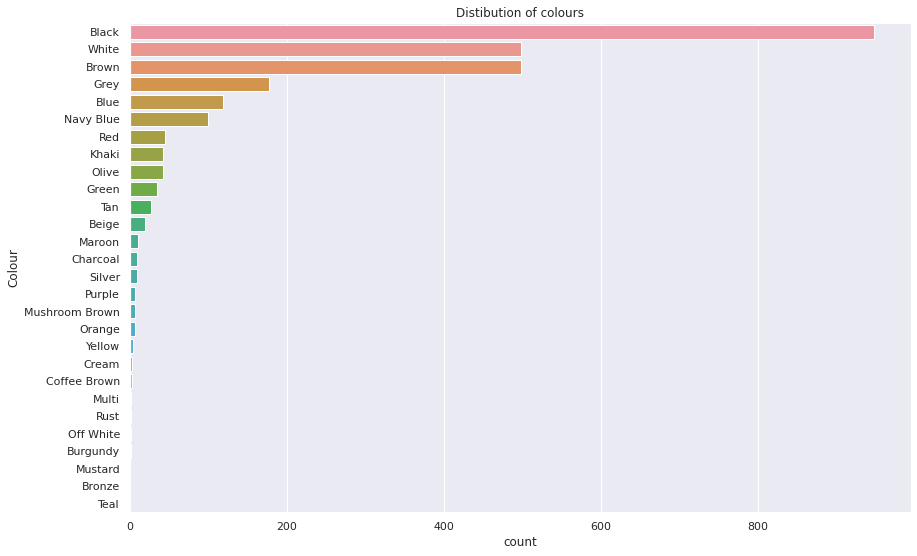

In [150]:
sns.set(rc={'figure.figsize':(14, 9)})

ax = sns.countplot(data=df, y='base_colour', orient='v', order = df['base_colour'].value_counts().index)
ax.set_title('Distibution of colours');
ax.set_ylabel('Colour');

##### The most popular colour - black. Base colour feature values are hardly unbalanced. We need to keep it in mind for ML activity

#### Season

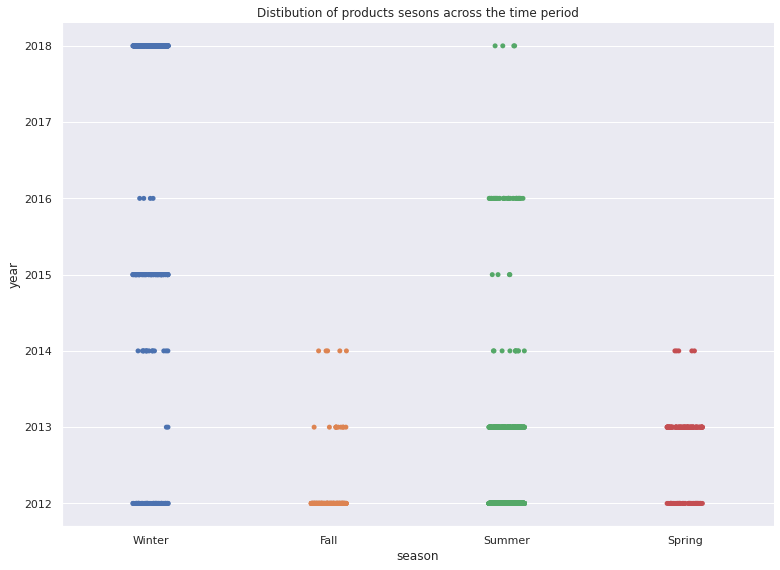

In [157]:
ax = sns.catplot(x="season", y='year', data=df)
ax.fig.set_size_inches(12,8)
ax.axes.flatten()[0].set_title('Distibution of products sesons across the time period');

##### We can see a strange trend - there is a lack for seasons (except Winter) for Men Shoes for the last years

#### Usage

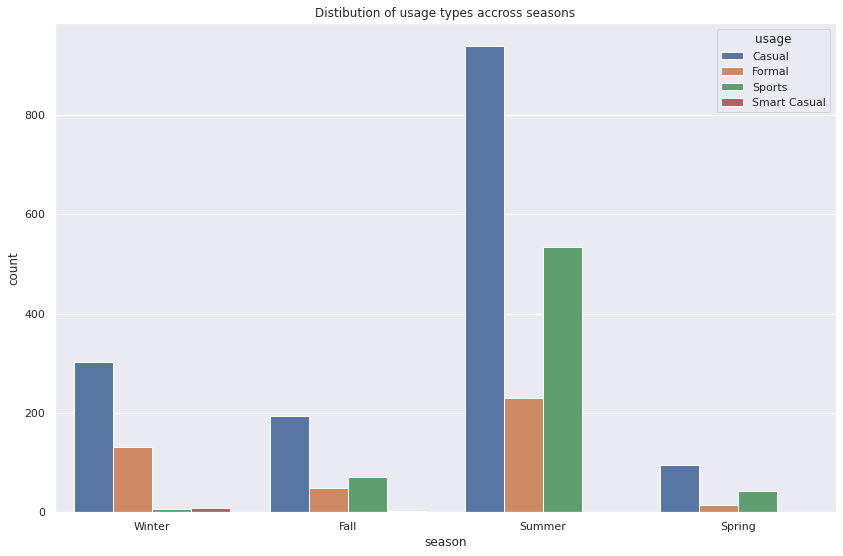

In [165]:
ax = sns.countplot(x="season", hue="usage", data=df)
ax.set_title('Distibution of usage types accross seasons');

##### Causal is a top usage, but we can see that Sports frequency is increased for Summer period